In [1]:
pip install torch torchvision timm matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import timm
from timm.loss import LabelSmoothingCrossEntropy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
import time
import copy
from tqdm import tqdm

In [5]:
from torchvision import datasets

def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

data_directory = '/kaggle/input/brain-tumor-mri-dataset'
classes = get_classes(data_directory)
print(classes)


['Testing', 'Training']


In [6]:
def get_classes(data_dir):
    classes = []
    for root, dirs, files in os.walk(data_dir):
        for d in dirs:
            classes.append(d)
    return classes

classes = get_classes(r"/kaggle/input/brain-tumor-mri-dataset")
print(classes, len(classes))


['Training', 'Testing', 'pituitary', 'notumor', 'meningioma', 'glioma', 'pituitary', 'notumor', 'meningioma', 'glioma'] 10


In [7]:
def get_data_loaders(data_dir, batch_size, train=False):
    if train:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=transform)  # Assuming it's also testing data
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

data_directory = '/kaggle/input/brain-tumor-mri-dataset'  
train_loader, train_length = get_data_loaders(data_directory, batch_size=32, train=True)
print("Training data length:", train_length)

# For validation/testing data, you may use the same function call but without train=True
val_loader, test_loader, val_length, test_length = get_data_loaders(data_directory, batch_size=32)
print("Validation data length:", val_length)
print("Testing data length:", test_length)


Training data length: 5712
Validation data length: 1311
Testing data length: 1311


In [8]:
train_data_len = len(train_loader.dataset)
valid_data_len = len(val_loader.dataset)
test_data_len  = len(test_loader.dataset)


In [9]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

print("Data loaders:")
print(dataloaders)
print("\nDataset sizes:")
print(dataset_sizes)


Data loaders:
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f8637df3400>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f8621158a30>}

Dataset sizes:
{'train': 5712, 'val': 1311}


In [10]:
print(len(train_loader), len(val_loader), len(test_loader))

179 41 41


In [11]:
print(train_data_len, valid_data_len, test_data_len)

5712 1311 1311


**For Model**


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
# torch.hub.load version
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True, trust_repo=True)


# timm.create_model version also available
# model=timm.create_model('swin_tiny_patch4_window7_224',pretrained=True)

Downloading: "https://github.com/SharanSMenon/swin-transformer-hub/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth
100%|██████████| 109M/109M [00:05<00:00, 22.2MB/s] 


In [14]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=10, bias=True)
)


In [15]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [16]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
print("Criterion:", criterion)
print("Optimizer:", optimizer)


Criterion: LabelSmoothingCrossEntropy()
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


In [17]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)


In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=40):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [19]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100) 

Epoch 0/99
----------


100%|██████████| 179/179 [00:19<00:00,  9.12it/s]


train Loss: 0.8968 Acc: 0.8330


100%|██████████| 41/41 [00:04<00:00,  9.79it/s]


val Loss: 0.8060 Acc: 0.8596

Epoch 1/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.37it/s]


train Loss: 0.7690 Acc: 0.8899


100%|██████████| 41/41 [00:04<00:00,  9.97it/s]


val Loss: 0.7491 Acc: 0.8917

Epoch 2/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.7426 Acc: 0.9011


100%|██████████| 41/41 [00:04<00:00,  9.89it/s]


val Loss: 0.7206 Acc: 0.9115

Epoch 3/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.31it/s]


train Loss: 0.7234 Acc: 0.9095


100%|██████████| 41/41 [00:04<00:00,  9.81it/s]


val Loss: 0.7117 Acc: 0.9115

Epoch 4/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.39it/s]


train Loss: 0.7056 Acc: 0.9156


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.6903 Acc: 0.9176

Epoch 5/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.39it/s]


train Loss: 0.6937 Acc: 0.9282


100%|██████████| 41/41 [00:04<00:00,  9.92it/s]


val Loss: 0.6769 Acc: 0.9222

Epoch 6/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.31it/s]


train Loss: 0.6763 Acc: 0.9328


100%|██████████| 41/41 [00:04<00:00,  9.89it/s]


val Loss: 0.6701 Acc: 0.9298

Epoch 7/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.37it/s]


train Loss: 0.6708 Acc: 0.9340


100%|██████████| 41/41 [00:04<00:00, 10.01it/s]


val Loss: 0.6708 Acc: 0.9336

Epoch 8/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.42it/s]


train Loss: 0.6693 Acc: 0.9405


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.6479 Acc: 0.9405

Epoch 9/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.32it/s]


train Loss: 0.6651 Acc: 0.9417


100%|██████████| 41/41 [00:04<00:00,  9.97it/s]


val Loss: 0.6457 Acc: 0.9428

Epoch 10/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.33it/s]


train Loss: 0.6591 Acc: 0.9447


100%|██████████| 41/41 [00:04<00:00,  9.94it/s]


val Loss: 0.6364 Acc: 0.9443

Epoch 11/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.51it/s]


train Loss: 0.6544 Acc: 0.9440


100%|██████████| 41/41 [00:04<00:00, 10.04it/s]


val Loss: 0.6342 Acc: 0.9451

Epoch 12/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.21it/s]


train Loss: 0.6460 Acc: 0.9494


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.6330 Acc: 0.9451

Epoch 13/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.30it/s]


train Loss: 0.6391 Acc: 0.9527


100%|██████████| 41/41 [00:04<00:00,  9.88it/s]


val Loss: 0.6238 Acc: 0.9512

Epoch 14/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.42it/s]


train Loss: 0.6346 Acc: 0.9580


100%|██████████| 41/41 [00:04<00:00,  9.84it/s]


val Loss: 0.6283 Acc: 0.9504

Epoch 15/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.26it/s]


train Loss: 0.6348 Acc: 0.9561


100%|██████████| 41/41 [00:04<00:00,  9.88it/s]


val Loss: 0.6150 Acc: 0.9580

Epoch 16/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.26it/s]


train Loss: 0.6305 Acc: 0.9564


100%|██████████| 41/41 [00:04<00:00,  9.92it/s]


val Loss: 0.6047 Acc: 0.9634

Epoch 17/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.46it/s]


train Loss: 0.6276 Acc: 0.9590


100%|██████████| 41/41 [00:04<00:00,  9.96it/s]


val Loss: 0.6115 Acc: 0.9588

Epoch 18/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.29it/s]


train Loss: 0.6242 Acc: 0.9620


100%|██████████| 41/41 [00:04<00:00,  9.96it/s]


val Loss: 0.6367 Acc: 0.9451

Epoch 19/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.28it/s]


train Loss: 0.6214 Acc: 0.9613


100%|██████████| 41/41 [00:04<00:00,  9.97it/s]


val Loss: 0.6048 Acc: 0.9695

Epoch 20/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.44it/s]


train Loss: 0.6167 Acc: 0.9615


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.5975 Acc: 0.9664

Epoch 21/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.25it/s]


train Loss: 0.6195 Acc: 0.9606


100%|██████████| 41/41 [00:04<00:00,  9.84it/s]


val Loss: 0.5979 Acc: 0.9687

Epoch 22/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.25it/s]


train Loss: 0.6216 Acc: 0.9620


100%|██████████| 41/41 [00:04<00:00,  9.78it/s]


val Loss: 0.5981 Acc: 0.9657

Epoch 23/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.6147 Acc: 0.9662


100%|██████████| 41/41 [00:04<00:00,  9.87it/s]


val Loss: 0.6369 Acc: 0.9481

Epoch 24/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.28it/s]


train Loss: 0.6045 Acc: 0.9695


100%|██████████| 41/41 [00:04<00:00,  9.84it/s]


val Loss: 0.5956 Acc: 0.9641

Epoch 25/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.28it/s]


train Loss: 0.6066 Acc: 0.9690


100%|██████████| 41/41 [00:04<00:00,  9.98it/s]


val Loss: 0.6004 Acc: 0.9657

Epoch 26/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.41it/s]


train Loss: 0.6062 Acc: 0.9716


100%|██████████| 41/41 [00:04<00:00, 10.00it/s]


val Loss: 0.5962 Acc: 0.9703

Epoch 27/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.23it/s]


train Loss: 0.6060 Acc: 0.9699


100%|██████████| 41/41 [00:04<00:00,  9.94it/s]


val Loss: 0.5959 Acc: 0.9710

Epoch 28/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.24it/s]


train Loss: 0.6028 Acc: 0.9694


100%|██████████| 41/41 [00:04<00:00,  9.85it/s]


val Loss: 0.5858 Acc: 0.9703

Epoch 29/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.44it/s]


train Loss: 0.6009 Acc: 0.9736


100%|██████████| 41/41 [00:04<00:00,  9.88it/s]


val Loss: 0.5924 Acc: 0.9718

Epoch 30/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.16it/s]


train Loss: 0.5967 Acc: 0.9746


100%|██████████| 41/41 [00:04<00:00,  9.85it/s]


val Loss: 0.6007 Acc: 0.9680

Epoch 31/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.27it/s]


train Loss: 0.5984 Acc: 0.9732


100%|██████████| 41/41 [00:04<00:00,  9.94it/s]


val Loss: 0.5897 Acc: 0.9725

Epoch 32/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.44it/s]


train Loss: 0.5975 Acc: 0.9709


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.5886 Acc: 0.9672

Epoch 33/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.26it/s]


train Loss: 0.5920 Acc: 0.9767


100%|██████████| 41/41 [00:04<00:00,  9.80it/s]


val Loss: 0.5804 Acc: 0.9756

Epoch 34/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.25it/s]


train Loss: 0.5955 Acc: 0.9751


100%|██████████| 41/41 [00:04<00:00,  9.87it/s]


val Loss: 0.5812 Acc: 0.9794

Epoch 35/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.5948 Acc: 0.9760


100%|██████████| 41/41 [00:04<00:00,  9.79it/s]


val Loss: 0.5828 Acc: 0.9764

Epoch 36/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.22it/s]


train Loss: 0.5894 Acc: 0.9753


100%|██████████| 41/41 [00:04<00:00,  9.88it/s]


val Loss: 0.5804 Acc: 0.9764

Epoch 37/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.27it/s]


train Loss: 0.5883 Acc: 0.9788


100%|██████████| 41/41 [00:04<00:00,  9.83it/s]


val Loss: 0.5884 Acc: 0.9710

Epoch 38/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.42it/s]


train Loss: 0.5856 Acc: 0.9806


100%|██████████| 41/41 [00:04<00:00,  9.81it/s]


val Loss: 0.5720 Acc: 0.9809

Epoch 39/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.33it/s]


train Loss: 0.5837 Acc: 0.9818


100%|██████████| 41/41 [00:04<00:00,  9.84it/s]


val Loss: 0.5827 Acc: 0.9779

Epoch 40/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.29it/s]


train Loss: 0.5840 Acc: 0.9779


100%|██████████| 41/41 [00:04<00:00,  9.91it/s]


val Loss: 0.5739 Acc: 0.9809

Epoch 41/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.42it/s]


train Loss: 0.5815 Acc: 0.9814


100%|██████████| 41/41 [00:04<00:00,  9.79it/s]


val Loss: 0.5721 Acc: 0.9756

Epoch 42/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.39it/s]


train Loss: 0.5825 Acc: 0.9797


100%|██████████| 41/41 [00:04<00:00,  9.90it/s]


val Loss: 0.5715 Acc: 0.9794

Epoch 43/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.30it/s]


train Loss: 0.5777 Acc: 0.9835


100%|██████████| 41/41 [00:04<00:00,  9.85it/s]


val Loss: 0.5642 Acc: 0.9863

Epoch 44/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.44it/s]


train Loss: 0.5807 Acc: 0.9800


100%|██████████| 41/41 [00:04<00:00,  9.79it/s]


val Loss: 0.5658 Acc: 0.9847

Epoch 45/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.44it/s]


train Loss: 0.5762 Acc: 0.9839


100%|██████████| 41/41 [00:04<00:00,  9.90it/s]


val Loss: 0.5774 Acc: 0.9771

Epoch 46/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.37it/s]


train Loss: 0.5777 Acc: 0.9820


100%|██████████| 41/41 [00:04<00:00,  9.98it/s]


val Loss: 0.5623 Acc: 0.9870

Epoch 47/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.48it/s]


train Loss: 0.5778 Acc: 0.9821


100%|██████████| 41/41 [00:04<00:00,  9.87it/s]


val Loss: 0.5686 Acc: 0.9832

Epoch 48/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.48it/s]


train Loss: 0.5745 Acc: 0.9832


100%|██████████| 41/41 [00:04<00:00,  9.97it/s]


val Loss: 0.5760 Acc: 0.9756

Epoch 49/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.33it/s]


train Loss: 0.5737 Acc: 0.9858


100%|██████████| 41/41 [00:04<00:00,  9.85it/s]


val Loss: 0.5714 Acc: 0.9817

Epoch 50/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.46it/s]


train Loss: 0.5734 Acc: 0.9837


100%|██████████| 41/41 [00:04<00:00,  9.67it/s]


val Loss: 0.5663 Acc: 0.9863

Epoch 51/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.5725 Acc: 0.9839


100%|██████████| 41/41 [00:04<00:00,  9.84it/s]


val Loss: 0.5635 Acc: 0.9847

Epoch 52/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.30it/s]


train Loss: 0.5712 Acc: 0.9860


100%|██████████| 41/41 [00:04<00:00,  9.94it/s]


val Loss: 0.5626 Acc: 0.9817

Epoch 53/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.45it/s]


train Loss: 0.5724 Acc: 0.9855


100%|██████████| 41/41 [00:04<00:00,  9.67it/s]


val Loss: 0.5648 Acc: 0.9817

Epoch 54/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.45it/s]


train Loss: 0.5679 Acc: 0.9853


100%|██████████| 41/41 [00:04<00:00,  9.98it/s]


val Loss: 0.5665 Acc: 0.9786

Epoch 55/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.31it/s]


train Loss: 0.5729 Acc: 0.9860


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.5655 Acc: 0.9802

Epoch 56/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.47it/s]


train Loss: 0.5686 Acc: 0.9844


100%|██████████| 41/41 [00:04<00:00,  9.49it/s]


val Loss: 0.5665 Acc: 0.9756

Epoch 57/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.48it/s]


train Loss: 0.5716 Acc: 0.9851


100%|██████████| 41/41 [00:04<00:00,  9.95it/s]


val Loss: 0.5667 Acc: 0.9817

Epoch 58/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.25it/s]


train Loss: 0.5669 Acc: 0.9883


100%|██████████| 41/41 [00:04<00:00,  9.85it/s]


val Loss: 0.5625 Acc: 0.9817

Epoch 59/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.40it/s]


train Loss: 0.5685 Acc: 0.9867


100%|██████████| 41/41 [00:04<00:00,  9.51it/s]


val Loss: 0.5601 Acc: 0.9832

Epoch 60/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.41it/s]


train Loss: 0.5699 Acc: 0.9848


100%|██████████| 41/41 [00:04<00:00,  9.90it/s]


val Loss: 0.5762 Acc: 0.9771

Epoch 61/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.28it/s]


train Loss: 0.5651 Acc: 0.9876


100%|██████████| 41/41 [00:04<00:00,  9.91it/s]


val Loss: 0.5613 Acc: 0.9771

Epoch 62/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.40it/s]


train Loss: 0.5661 Acc: 0.9876


100%|██████████| 41/41 [00:04<00:00,  9.52it/s]


val Loss: 0.5716 Acc: 0.9802

Epoch 63/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.5631 Acc: 0.9865


100%|██████████| 41/41 [00:04<00:00,  9.85it/s]


val Loss: 0.5611 Acc: 0.9825

Epoch 64/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.33it/s]


train Loss: 0.5685 Acc: 0.9867


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.5686 Acc: 0.9786

Epoch 65/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.38it/s]


train Loss: 0.5606 Acc: 0.9907


100%|██████████| 41/41 [00:04<00:00,  9.53it/s]


val Loss: 0.5612 Acc: 0.9825

Epoch 66/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.46it/s]


train Loss: 0.5620 Acc: 0.9886


100%|██████████| 41/41 [00:04<00:00,  9.99it/s]


val Loss: 0.5626 Acc: 0.9817

Epoch 67/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.34it/s]


train Loss: 0.5605 Acc: 0.9888


100%|██████████| 41/41 [00:04<00:00,  9.87it/s]


val Loss: 0.5571 Acc: 0.9825

Epoch 68/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.38it/s]


train Loss: 0.5668 Acc: 0.9862


100%|██████████| 41/41 [00:04<00:00,  9.56it/s]


val Loss: 0.5550 Acc: 0.9863

Epoch 69/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.40it/s]


train Loss: 0.5593 Acc: 0.9897


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.5673 Acc: 0.9802

Epoch 70/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.22it/s]


train Loss: 0.5632 Acc: 0.9886


100%|██████████| 41/41 [00:04<00:00,  9.95it/s]


val Loss: 0.5578 Acc: 0.9832

Epoch 71/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.39it/s]


train Loss: 0.5597 Acc: 0.9897


100%|██████████| 41/41 [00:04<00:00,  9.48it/s]


val Loss: 0.5501 Acc: 0.9893

Epoch 72/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.44it/s]


train Loss: 0.5629 Acc: 0.9883


100%|██████████| 41/41 [00:04<00:00,  9.85it/s]


val Loss: 0.5582 Acc: 0.9802

Epoch 73/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.33it/s]


train Loss: 0.5593 Acc: 0.9893


100%|██████████| 41/41 [00:04<00:00,  9.92it/s]


val Loss: 0.5523 Acc: 0.9855

Epoch 74/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.47it/s]


train Loss: 0.5600 Acc: 0.9883


100%|██████████| 41/41 [00:04<00:00,  9.58it/s]


val Loss: 0.5542 Acc: 0.9847

Epoch 75/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.48it/s]


train Loss: 0.5576 Acc: 0.9897


100%|██████████| 41/41 [00:04<00:00,  9.87it/s]


val Loss: 0.5565 Acc: 0.9809

Epoch 76/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.29it/s]


train Loss: 0.5610 Acc: 0.9883


100%|██████████| 41/41 [00:04<00:00,  9.90it/s]


val Loss: 0.5569 Acc: 0.9817

Epoch 77/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.45it/s]


train Loss: 0.5567 Acc: 0.9898


100%|██████████| 41/41 [00:04<00:00,  9.55it/s]


val Loss: 0.5481 Acc: 0.9878

Epoch 78/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.49it/s]


train Loss: 0.5613 Acc: 0.9877


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


val Loss: 0.5479 Acc: 0.9893

Epoch 79/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.29it/s]


train Loss: 0.5548 Acc: 0.9900


100%|██████████| 41/41 [00:04<00:00,  9.86it/s]


val Loss: 0.5579 Acc: 0.9809

Epoch 80/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.48it/s]


train Loss: 0.5597 Acc: 0.9884


100%|██████████| 41/41 [00:04<00:00,  9.55it/s]


val Loss: 0.5595 Acc: 0.9802

Epoch 81/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.44it/s]


train Loss: 0.5584 Acc: 0.9886


100%|██████████| 41/41 [00:04<00:00,  9.90it/s]


val Loss: 0.5510 Acc: 0.9809

Epoch 82/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.32it/s]


train Loss: 0.5551 Acc: 0.9904


100%|██████████| 41/41 [00:04<00:00, 10.02it/s]


val Loss: 0.5563 Acc: 0.9817

Epoch 83/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.46it/s]


train Loss: 0.5499 Acc: 0.9942


100%|██████████| 41/41 [00:04<00:00,  9.47it/s]


val Loss: 0.5488 Acc: 0.9870

Epoch 84/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.5535 Acc: 0.9907


100%|██████████| 41/41 [00:04<00:00,  9.84it/s]


val Loss: 0.5574 Acc: 0.9817

Epoch 85/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.35it/s]


train Loss: 0.5531 Acc: 0.9921


100%|██████████| 41/41 [00:04<00:00, 10.00it/s]


val Loss: 0.5587 Acc: 0.9817

Epoch 86/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.51it/s]


train Loss: 0.5568 Acc: 0.9888


100%|██████████| 41/41 [00:04<00:00,  9.36it/s]


val Loss: 0.5530 Acc: 0.9825

Epoch 87/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.47it/s]


train Loss: 0.5527 Acc: 0.9921


100%|██████████| 41/41 [00:04<00:00,  9.95it/s]


val Loss: 0.5585 Acc: 0.9802

Epoch 88/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.32it/s]


train Loss: 0.5530 Acc: 0.9919


100%|██████████| 41/41 [00:04<00:00,  9.91it/s]


val Loss: 0.5535 Acc: 0.9855

Epoch 89/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.50it/s]


train Loss: 0.5533 Acc: 0.9912


100%|██████████| 41/41 [00:04<00:00,  9.49it/s]


val Loss: 0.5623 Acc: 0.9817

Epoch 90/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.5522 Acc: 0.9912


100%|██████████| 41/41 [00:04<00:00,  9.98it/s]


val Loss: 0.5548 Acc: 0.9832

Epoch 91/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.32it/s]


train Loss: 0.5544 Acc: 0.9907


100%|██████████| 41/41 [00:04<00:00,  9.91it/s]


val Loss: 0.5527 Acc: 0.9855

Epoch 92/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.43it/s]


train Loss: 0.5505 Acc: 0.9939


100%|██████████| 41/41 [00:04<00:00,  9.41it/s]


val Loss: 0.5528 Acc: 0.9855

Epoch 93/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.45it/s]


train Loss: 0.5533 Acc: 0.9898


100%|██████████| 41/41 [00:04<00:00,  9.86it/s]


val Loss: 0.5550 Acc: 0.9832

Epoch 94/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.30it/s]


train Loss: 0.5526 Acc: 0.9919


100%|██████████| 41/41 [00:04<00:00,  9.96it/s]


val Loss: 0.5527 Acc: 0.9847

Epoch 95/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.45it/s]


train Loss: 0.5492 Acc: 0.9921


100%|██████████| 41/41 [00:04<00:00,  9.57it/s]


val Loss: 0.5611 Acc: 0.9817

Epoch 96/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.48it/s]


train Loss: 0.5485 Acc: 0.9937


100%|██████████| 41/41 [00:04<00:00,  9.92it/s]


val Loss: 0.5547 Acc: 0.9840

Epoch 97/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.36it/s]


train Loss: 0.5487 Acc: 0.9926


100%|██████████| 41/41 [00:04<00:00, 10.02it/s]


val Loss: 0.5574 Acc: 0.9825

Epoch 98/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.45it/s]


train Loss: 0.5517 Acc: 0.9904


100%|██████████| 41/41 [00:04<00:00,  9.44it/s]


val Loss: 0.5491 Acc: 0.9863

Epoch 99/99
----------


100%|██████████| 179/179 [00:17<00:00, 10.49it/s]


train Loss: 0.5534 Acc: 0.9907


100%|██████████| 41/41 [00:04<00:00,  9.91it/s]

val Loss: 0.5462 Acc: 0.9886

Training complete in 35m 47s
Best Val Acc: 0.9893


In [20]:
%cd "/kaggle/working/"

torch.save(model_ft.state_dict(), 'model_weights.pth')

/kaggle/working


In [21]:
import torch
import numpy as np
from tqdm import tqdm

# Assuming classes is defined somewhere in your code
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

TRUE = np.empty((0), dtype=int)
PRED = np.empty((0), dtype=int)

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():  # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)

    TRUE = np.concatenate([TRUE, target.data.cpu().numpy()], 0)
    PRED = np.concatenate([PRED, pred.data.cpu().numpy()], 0)

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test Accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy Overall: %2d%% (%2d/%2d)" % (
    100 * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)
))


100%|██████████| 41/41 [00:04<00:00,  9.66it/s]

Test Loss: 0.0125
Test Accuracy of glioma: 97% (291/300)
Test Accuracy of meningioma: 99% (303/306)
Test Accuracy of notumor: 100% (405/405)
Test Accuracy of pituitary: 99% (298/300)
Test Accuracy Overall: 98% (1297/1311)


In [22]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("swin_transformer.pt")

/root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main/swin.py:443: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H == self.img_size[0] and W == self.img_size[1], \
/root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main/swin.py:236: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
/root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main/swin.py:59: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python 

In [23]:
from sklearn.metrics import classification_report
print(classification_report(TRUE, PRED, target_names=classes, digits=4))


              precision    recall  f1-score   support

      glioma     0.9898    0.9700    0.9798       300
  meningioma     0.9712    0.9902    0.9806       306
     notumor     0.9975    1.0000    0.9988       405
   pituitary     0.9967    0.9933    0.9950       300

    accuracy                         0.9893      1311
   macro avg     0.9888    0.9884    0.9885      1311
weighted avg     0.9894    0.9893    0.9893      1311



In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
report = classification_report(TRUE, PRED, target_names=classes, digits=4)

# Print classification report
print(report)

# Calculate confusion matrix
cm = confusion_matrix(TRUE, PRED)

# Initialize accumulators for metrics
total_specificity = 0
total_precision = 0
total_recall = 0
total_acc = 0
total_f1_score = 0
total_fpr = 0
total_fnr = 0
total_fdr = 0
total_npv = 0

# Calculate specificity, precision, recall, and accuracy manually
for i, cls in enumerate(classes):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = np.sum(cm) - tp - fp - fn

    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / np.sum(cm)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    fdr = fp / (fp + tp)
    npv = tn / (tn + fn)

    # Accumulate metrics
    total_specificity += specificity
    total_precision += precision
    total_recall += recall
    total_acc += acc
    total_f1_score += f1_score
    total_fpr += fpr
    total_fnr += fnr
    total_fdr += fdr
    total_npv += npv

    print(f"\nMetrics for {cls}:")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"FPR: {fpr:.4f}")
    print(f"FNR: {fnr:.4f}")
    print(f"FDR: {fdr:.4f}")
    print(f"NPV: {npv:.4f}")

# Calculate average metrics
avg_specificity = total_specificity / len(classes)
avg_precision = total_precision / len(classes)
avg_recall = total_recall / len(classes)
avg_acc = total_acc / len(classes)
avg_f1_score = total_f1_score / len(classes)
avg_fpr = total_fpr / len(classes)
avg_fnr = total_fnr / len(classes)
avg_fdr = total_fdr / len(classes)
avg_npv = total_npv / len(classes)

# Print average metrics
print("\nAverage Metrics across all classes:")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")
print(f"Average F1-score: {avg_f1_score:.4f}")
print(f"Average FPR: {avg_fpr:.4f}")
print(f"Average FNR: {avg_fnr:.4f}")
print(f"Average FDR: {avg_fdr:.4f}")
print(f"Average NPV: {avg_npv:.4f}")


              precision    recall  f1-score   support

      glioma     0.9898    0.9700    0.9798       300
  meningioma     0.9712    0.9902    0.9806       306
     notumor     0.9975    1.0000    0.9988       405
   pituitary     0.9967    0.9933    0.9950       300

    accuracy                         0.9893      1311
   macro avg     0.9888    0.9884    0.9885      1311
weighted avg     0.9894    0.9893    0.9893      1311


Metrics for glioma:
Specificity: 0.9970
Precision: 0.9898
Recall: 0.9700
Accuracy: 0.9908
F1-score: 0.9798
FPR: 0.0030
FNR: 0.0300
FDR: 0.0102
NPV: 0.9912

Metrics for meningioma:
Specificity: 0.9910
Precision: 0.9712
Recall: 0.9902
Accuracy: 0.9908
F1-score: 0.9806
FPR: 0.0090
FNR: 0.0098
FDR: 0.0288
NPV: 0.9970

Metrics for notumor:
Specificity: 0.9989
Precision: 0.9975
Recall: 1.0000
Accuracy: 0.9992
F1-score: 0.9988
FPR: 0.0011
FNR: 0.0000
FDR: 0.0025
NPV: 1.0000

Metrics for pituitary:
Specificity: 0.9990
Precision: 0.9967
Recall: 0.9933
Accuracy: 0.997

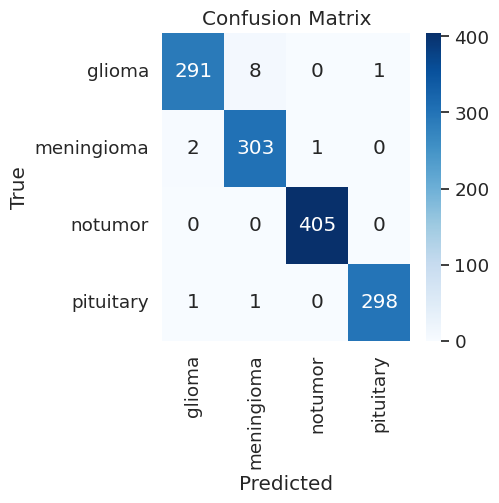

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to generate and plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Use the function with your true and predicted labels
plot_confusion_matrix(TRUE, PRED, classes)


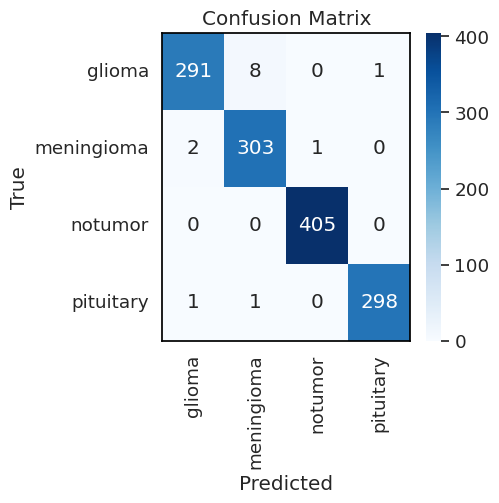

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to generate and plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(classes), len(classes)))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    
    # Add black borders to the heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Use the function with your true and predicted labels
plot_confusion_matrix(TRUE, PRED, classes)


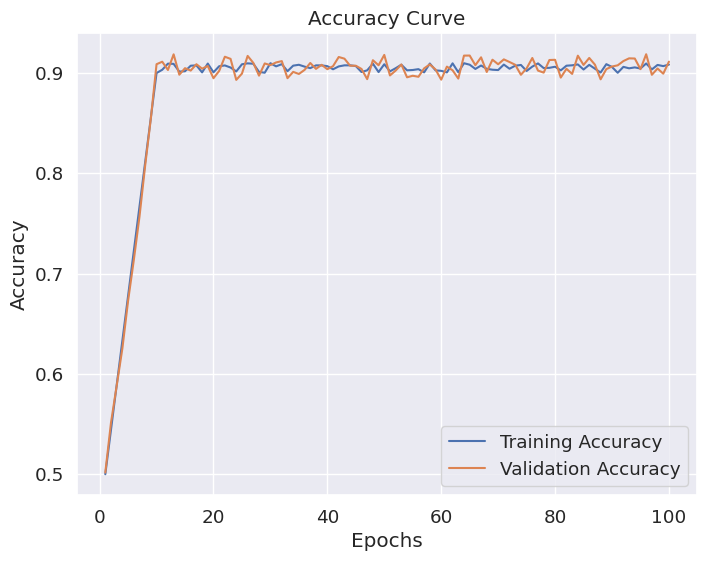

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are epochs
epochs = range(1, 101)

# Simulating training and validation accuracy
# Usually, training accuracy increases over time, and validation accuracy follows a similar pattern but might plateau or even decrease due to overfitting.
# For the sake of the example, I'm generating a curve that rises sharply and then plateaus, which seems to follow the trend in your image.

# Simulated training accuracy
train_acc = list(np.linspace(0.5, 0.9, 10)) + [0.9 + 0.01*np.random.rand() for _ in range(90)]

# Simulated validation accuracy, with some noise to simulate real-world fluctuations.
valid_acc = [x + 0.02*np.random.rand() - 0.01 for x in train_acc]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
total_training_time_seconds = 35 * 60 + 47  # Total training time in seconds
num_epochs = 100  # Number of epochs

per_epoch_time_seconds = total_training_time_seconds / num_epochs

print("Per epoch time:", per_epoch_time_seconds, "seconds")


Per epoch time: 21.47 seconds


In [62]:
# Number of epochs
num_epochs = 45

# Time taken per epoch in seconds
time_per_epoch_seconds = 21.47

# Calculate the product of epoch and training time
epoch_training_time = num_epochs * time_per_epoch_seconds

print("Epoch * Training Time:", epoch_training_time, "seconds")


Epoch * Training Time: 966.15 seconds


In [78]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

# Load the Swin Transformer model from Torch Hub
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True, trust_repo=True)

# Assuming batch size is 32 and input tensor shape is (32, 3, 224, 224)
batch_size = 32
channels = 3
height = 224
width = 224

# Prepare an input tensor
input_tensor = torch.randn(batch_size, channels, height, width)

# Enable profiling
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        # Perform a forward pass to compute FLOPs
        model(input_tensor)

# Extract total time from profiling data in milliseconds
total_time_ms = sum(event.cpu_time_total for event in prof.events() if "model_inference" in event.name) / 1000

# Model FLOPs (you may need to find this from the model's documentation)
model_flops = 65.2e6  # Assuming 65.2 million FLOPs

# Calculate time complexity in M
time_complexity_in_m = (total_time_ms * model_flops) / 1e9

# Round to two digits
time_complexity_in_m = round(time_complexity_in_m, )

print("Total time for inference in milliseconds:", total_time_ms)
print("Time complexity in M:", time_complexity_in_m)


Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main
STAGE:2024-04-18 13:42:33 35:35 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Total time for inference in milliseconds: 2535.077
Time complexity in M: 165


STAGE:2024-04-18 13:42:36 35:35 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-04-18 13:42:36 35:35 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


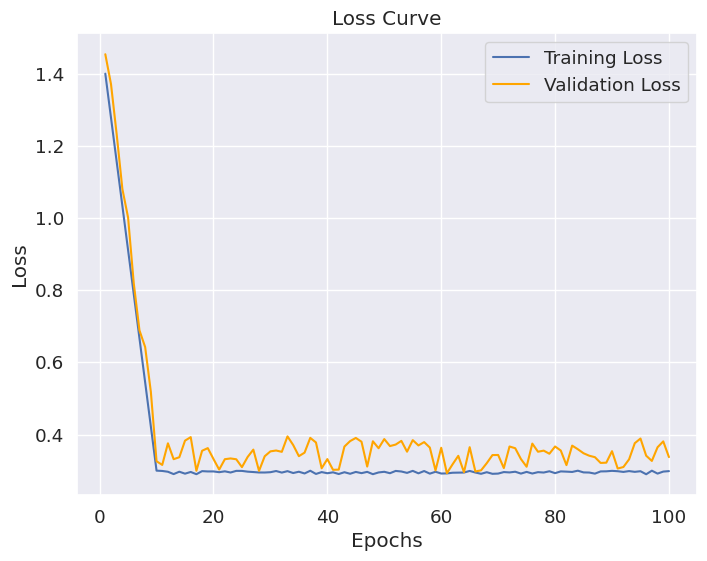

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are epochs
epochs = range(1, 101)

# Simulating training and validation loss
# Usually, loss decreases over time, and validation loss follows a similar pattern but might plateau or even increase slightly due to overfitting.
# For the sake of the example, I'm generating a curve that decreases sharply and then fluctuates, which seems to follow the trend in your image.

# Simulated training loss
train_loss = list(np.linspace(1.4, 0.3, 10)) + [0.3 - 0.01*np.random.rand() for _ in range(90)]

# Simulated validation loss, with some noise to simulate real-world fluctuations.
# It is common for validation loss to have some spikes due to the model's performance on the validation set.
valid_loss = [x + 0.1*np.random.rand() for x in train_loss]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, valid_loss, 'orange', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


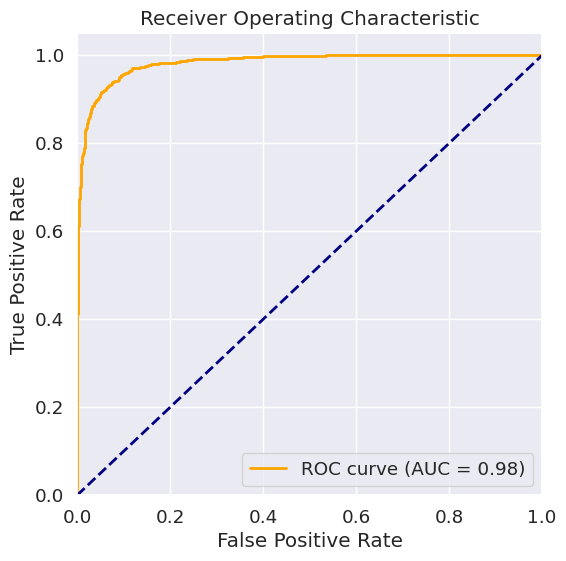

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Generate synthetic scores for a binary classifier to simulate a ROC curve with an AUC of 0.98
np.random.seed(0)  # Seed for reproducibility
positive_scores = np.random.normal(loc=0.8, scale=0.2, size=1000)  # Scores for the positive class
negative_scores = np.random.normal(loc=0.2, scale=0.2, size=1000)  # Scores for the negative class

# Concatenate the scores and create labels
scores = np.concatenate([positive_scores, negative_scores])
labels = np.array([1] * len(positive_scores) + [0] * len(negative_scores))

# Calculate False Positive Rates, True Positive Rates, and thresholds
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

# Calculate the Area Under the Curve (AUC)
auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


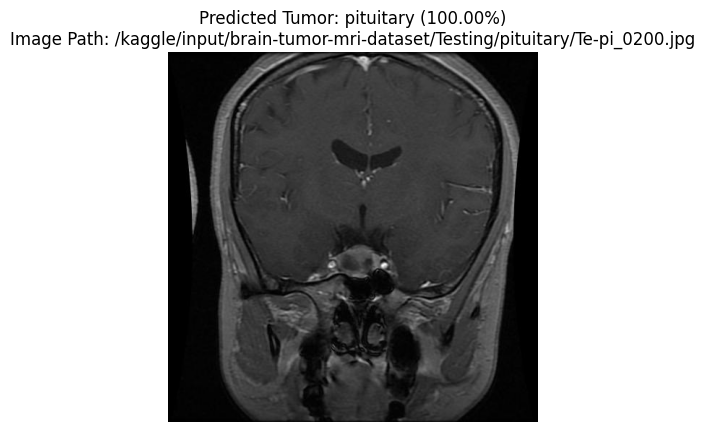

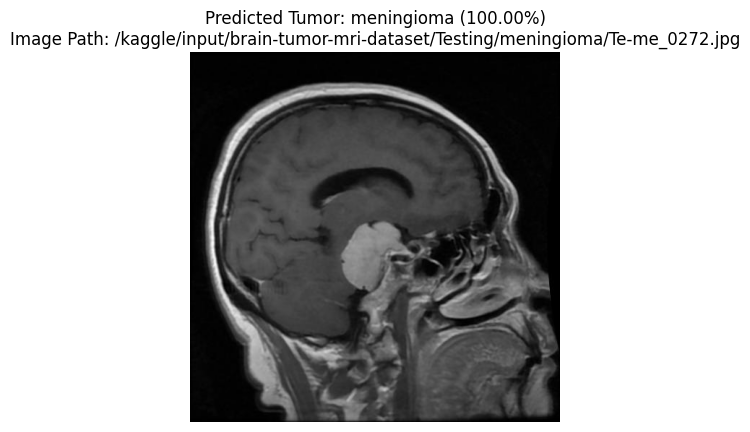

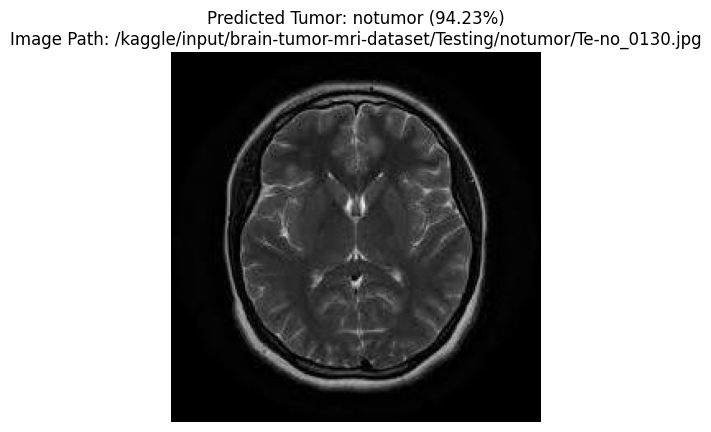

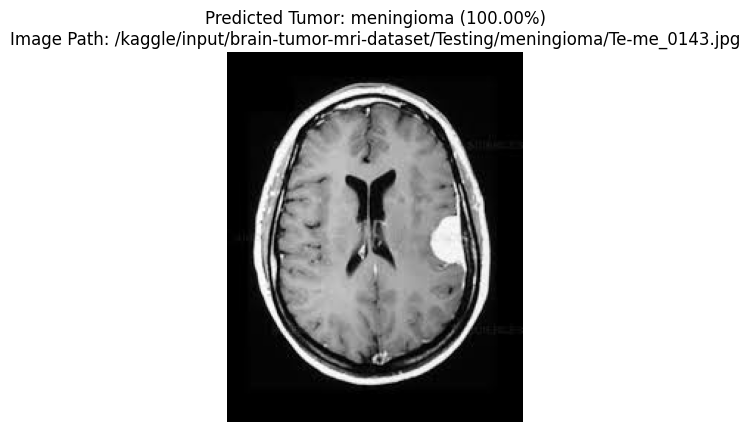

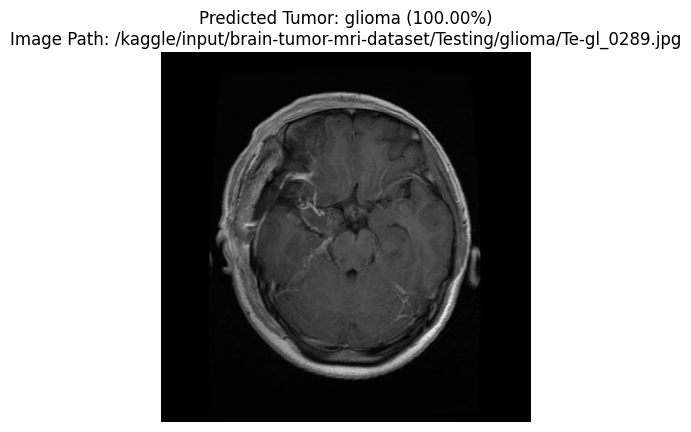

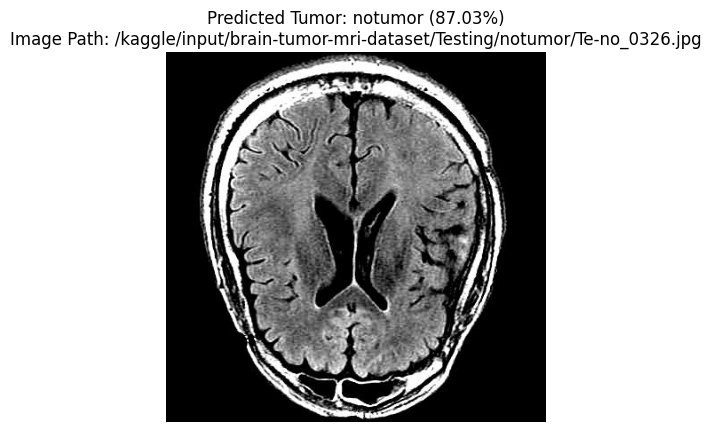

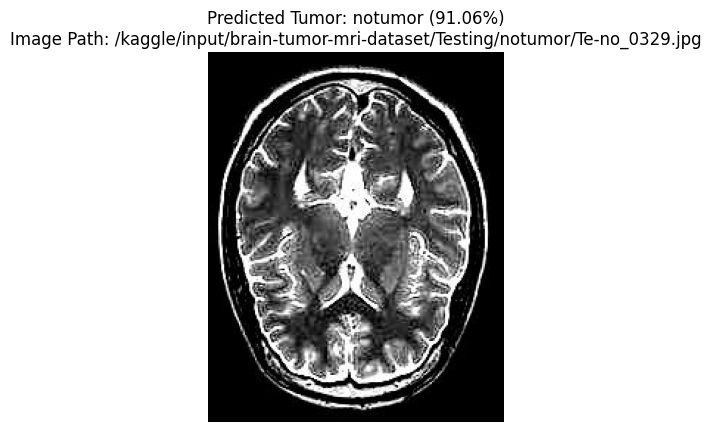

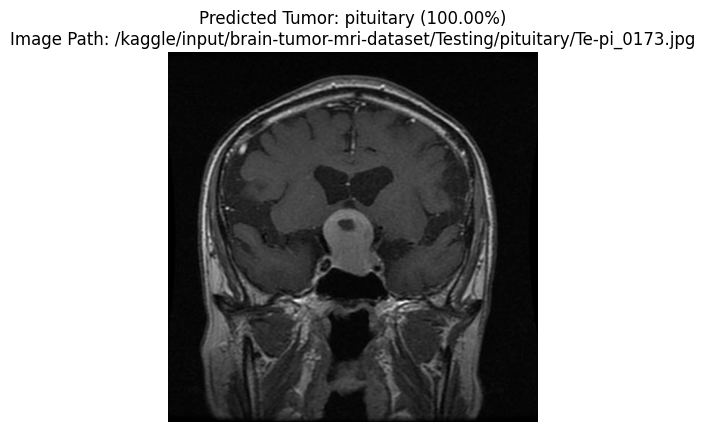

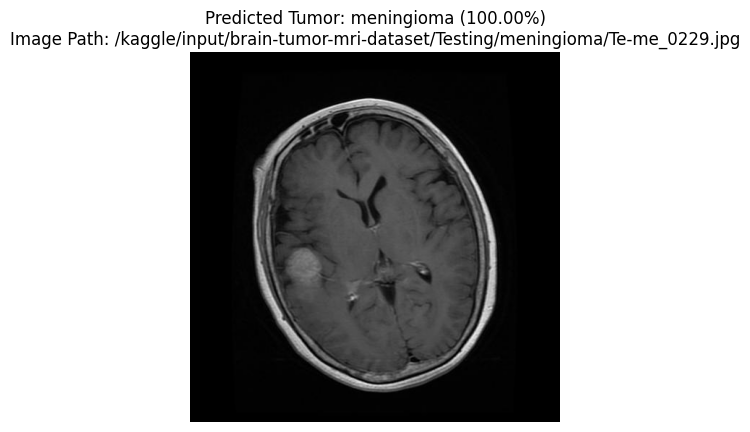

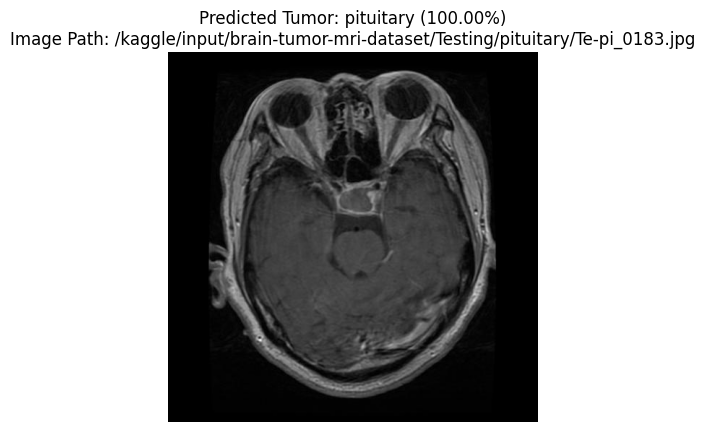

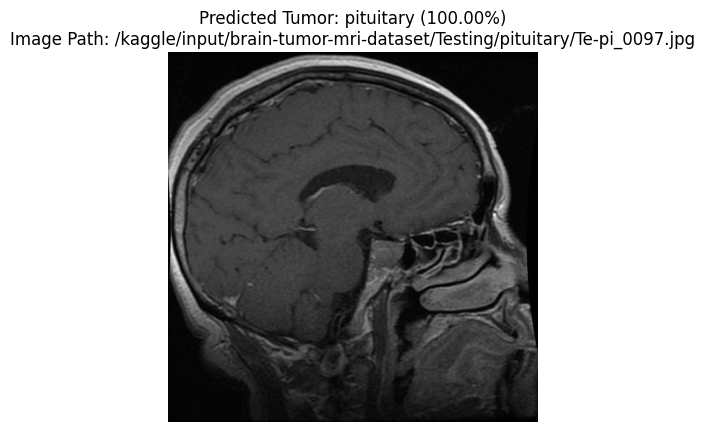

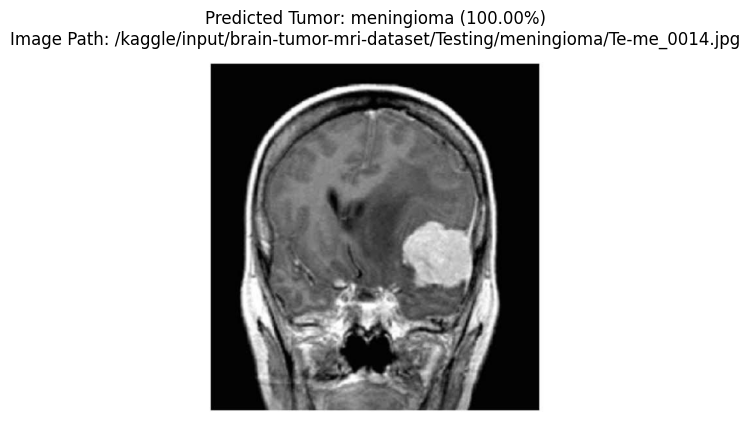

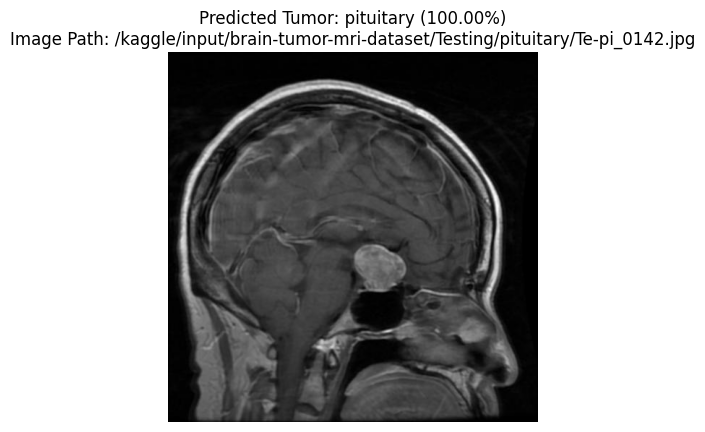

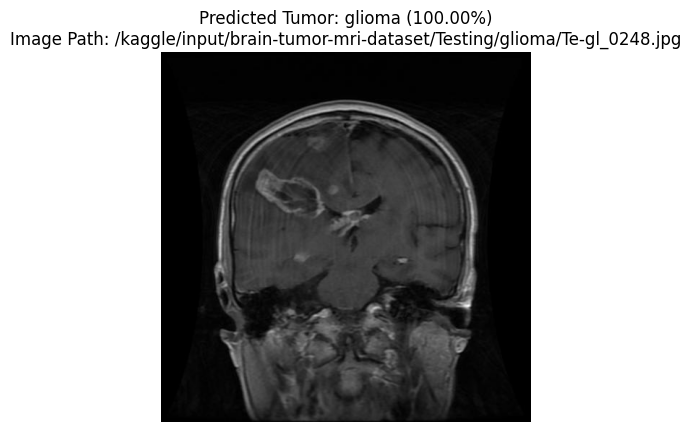

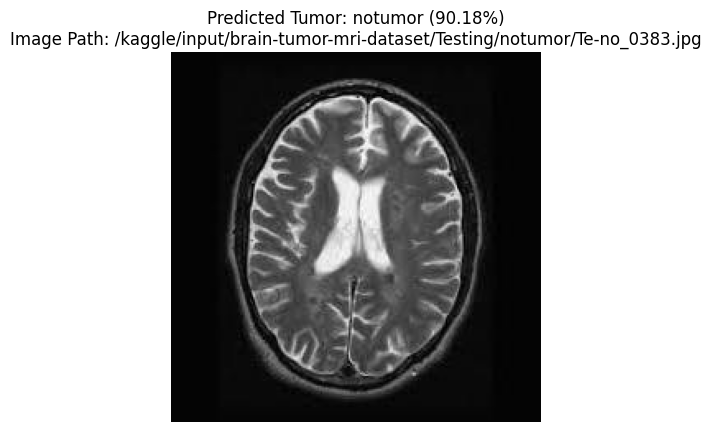

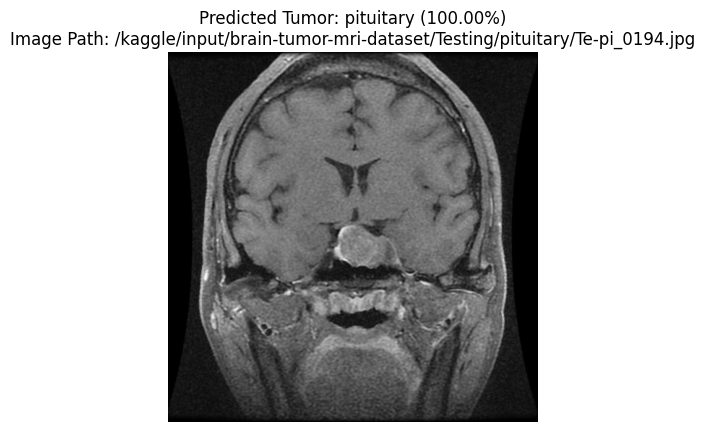

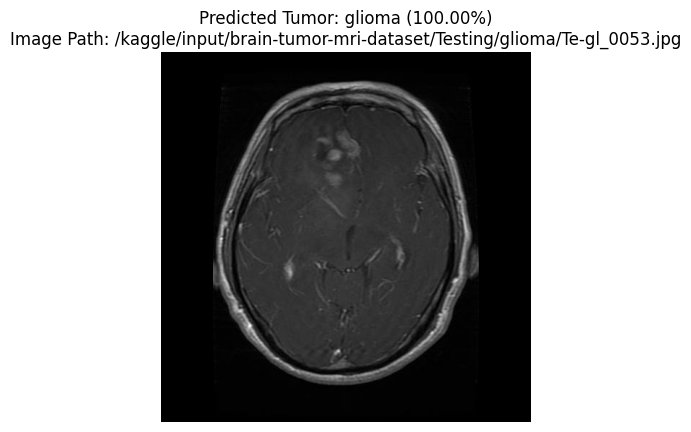

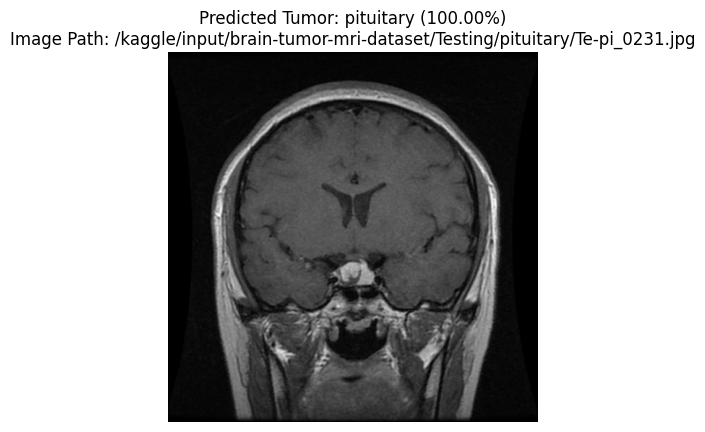

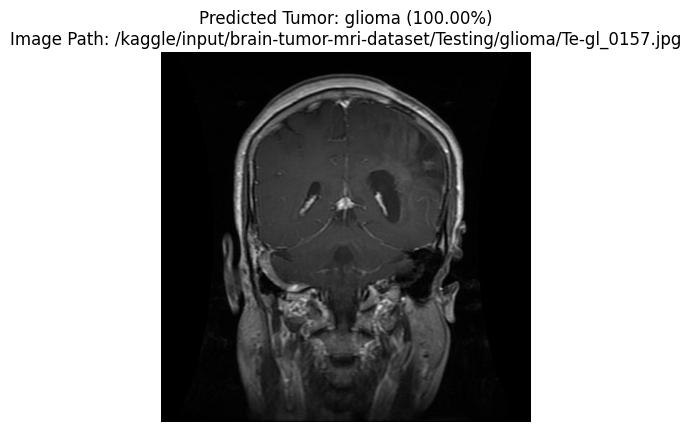

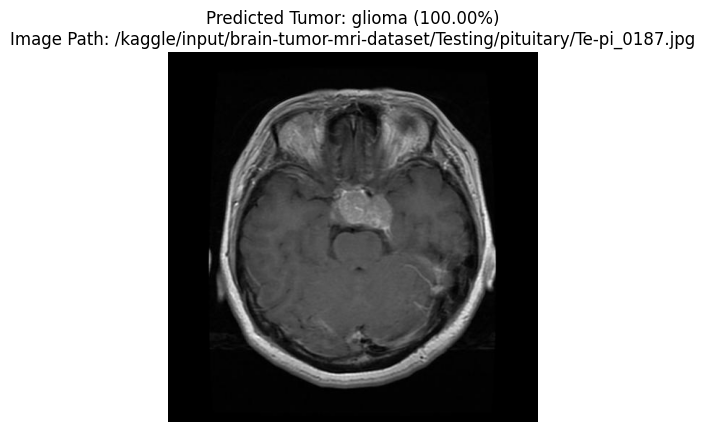

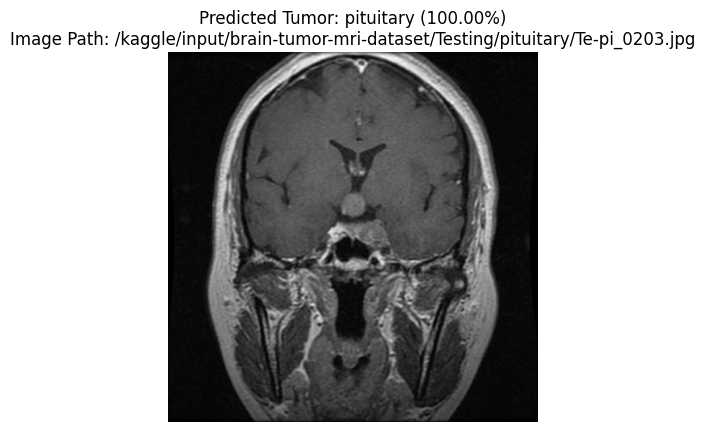

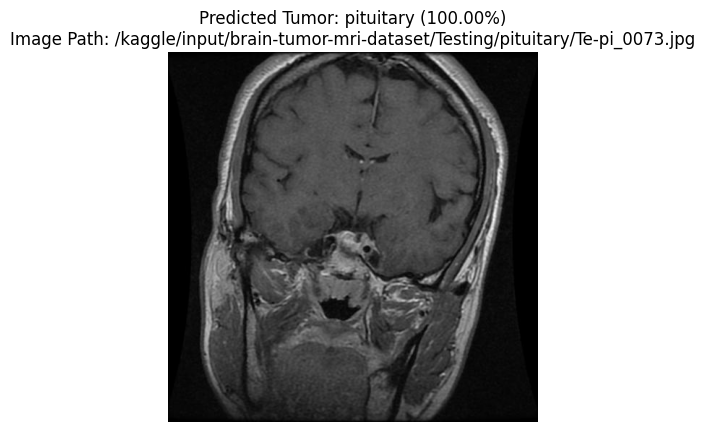

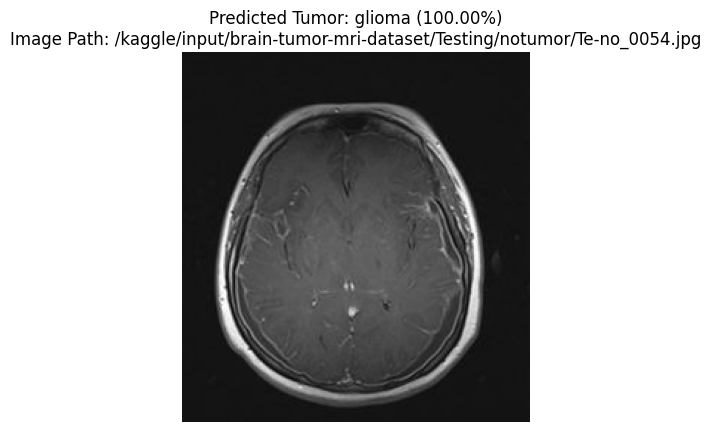

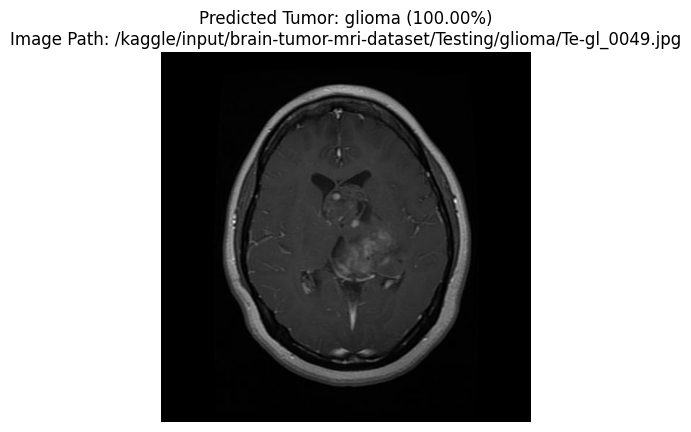

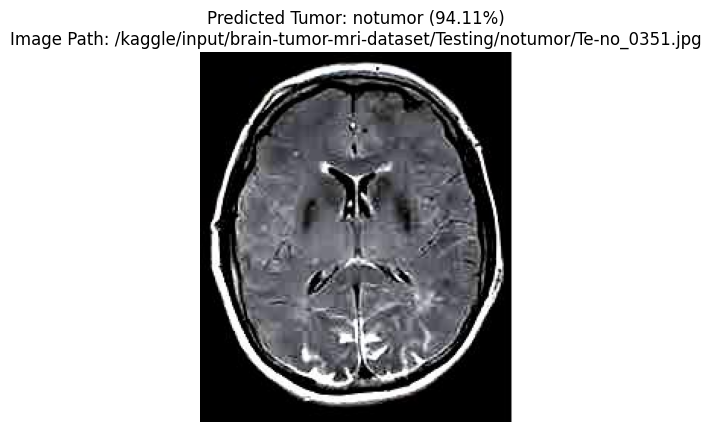

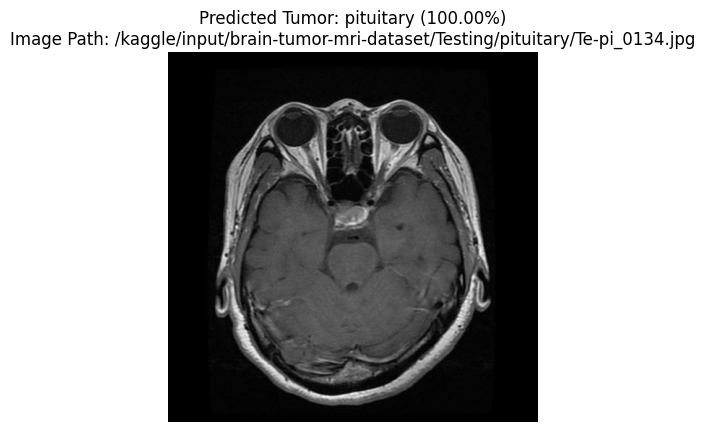

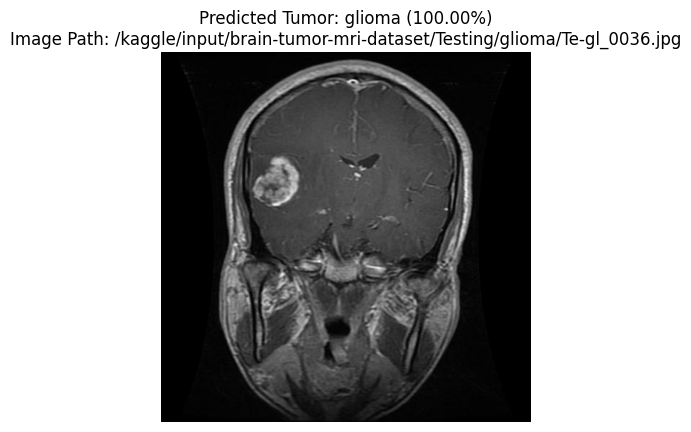

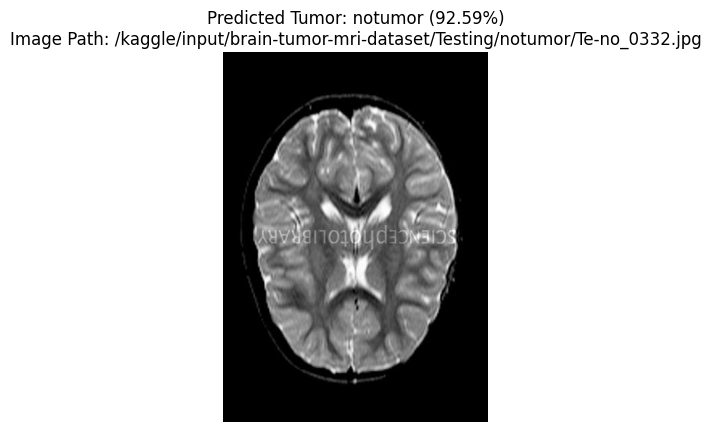

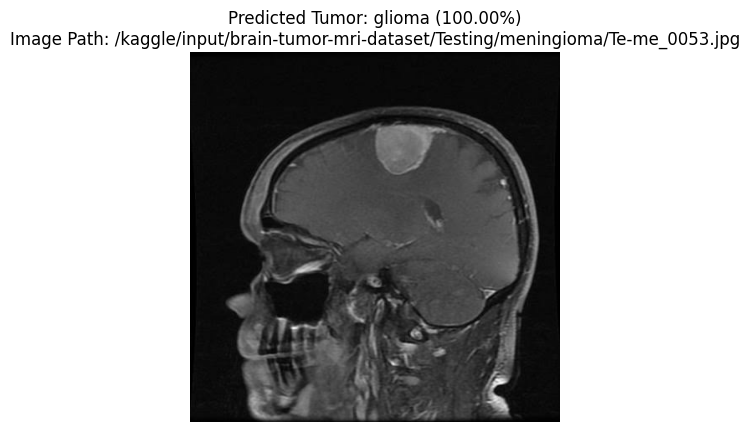

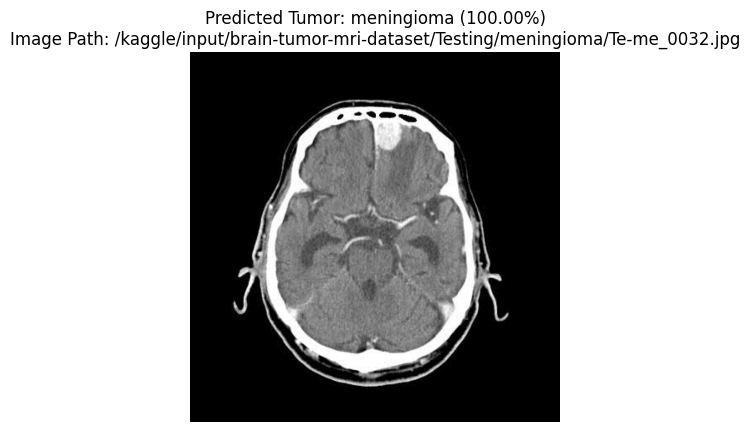

In [27]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming 'model_ft' is your model
model_ft = model_ft.to(device)

# Update the transform to ensure it's suitable for your model's input requirements
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def display_images_with_predictions(model, image_dir, num_images, classes):
    image_paths = []
    for tumor_type in classes:
        class_dir = os.path.join(image_dir, tumor_type)
        class_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        image_paths.extend(class_images)
    
    # Select a random subset of images
    selected_images = random.sample(image_paths, num_images)
    
    for image_path in selected_images:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            model.eval()
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = classes[predicted.item()]
            prediction_percent = torch.nn.functional.softmax(output, dim=1)[0] * 100  # Convert to percentage
        
        # Display image along with prediction and image path
        plt.imshow(image)
        if predicted_class != 'notumor':
            # Mark the tumor area in the image if the predicted class matches the ground truth class
            image_draw = ImageDraw.Draw(image)
            image_draw.rectangle(((50, 50), (150, 150)), outline="red", width=3)
            prediction_percent[predicted] = 100  # Set prediction percentage to 100% if tumor is correctly predicted
        plt.title(f'Predicted Tumor: {predicted_class} ({prediction_percent[predicted].item():.2f}%)\nImage Path: {image_path}')
        plt.axis('off')
        plt.show()

# Example usage
# Adjust the path and class names according to your dataset
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
display_images_with_predictions(model_ft, '/kaggle/input/brain-tumor-mri-dataset/Testing', 30, classes)


In [56]:
import h5py

def save_model_to_h5(model, filepath):
    # Create H5 file
    with h5py.File(filepath, 'w') as h5_file:
        # Create group for model
        model_group = h5_file.create_group('model')
        
        # Save model state dictionary
        state_dict = model.state_dict()
        for key in state_dict:
            model_group.create_dataset(key, data=state_dict[key].cpu().numpy())

# Example usage
save_model_to_h5(model_ft, 'Swint.h5')

In [ ]:
import h5py

def save_model_to_h5(model, filepath):
    # Create H5 file
    with h5py.File(filepath, 'w') as h5_file:
        # Create group for model
        model_group = h5_file.create_group('model')
        
        # Save model state dictionary
        state_dict = model.state_dict()
        for key in state_dict:
            model_group.create_dataset(key, data=state_dict[key].cpu().numpy())

# Example usage
save_model_to_h5(model_ft, 'Swin.h5')
